<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/autoencoder_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding a classification head to an autoencoder

Adapted from
- Autoencoder tutorial: https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/

Created: 5/26/2021

Adds a separate classification head to an autoencoder to allow latent representation to be classified.

In [1]:
# import time

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.decomposition import PCA

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import backend as K

# from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
latent_dim = 2
input_shape = (28, 28, 1)
epochs = 10
batch_size = 128
num_classes = 10
learning_rate = 5e-4

## Define the models

In [3]:
def encoder(input_shape):
    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(latent_dim, name='latent_out')(x)
    model = tf.keras.Model(inputs, x, name='encoder')
    return model

In [4]:
def decoder():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    model = tf.keras.Model(inputs, outputs, name="decoder")
    return model

In [5]:
def classifier():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    outp = layers.Dense(num_classes, activation="softmax", name='classifier_out')(inputs)
    model = tf.keras.Model(inputs, outp, name="classifier")
    return model

## Data

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)


# One-hot encode the labels
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_train_one_hot shape:', y_train.shape)

n_train = x_train.shape[0]

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_train_one_hot shape: (60000,)


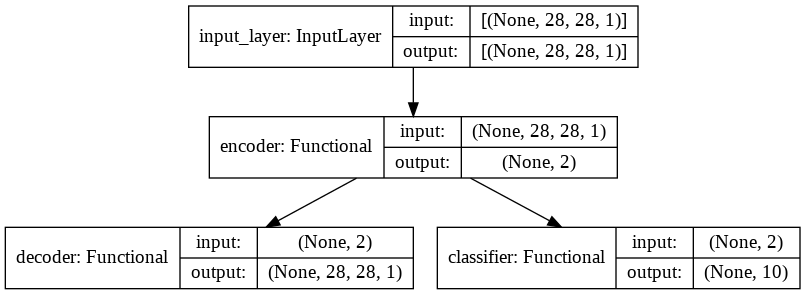

In [7]:
inputs = keras.Input(shape=input_shape, name='input_layer')

enc = encoder(input_shape)
dec = decoder()
clf = classifier()

model = tf.keras.Model(
			inputs=inputs,
			outputs=[dec(enc(inputs)), clf(enc(inputs))],
			name="baseline")

# plot the autoencoder
tf.keras.utils.plot_model(model, 'autoencoder_classifier.png', show_shapes=True)

## Train the model

In [8]:
losses = {
    'decoder': 'mse',
    'classifier': 'categorical_crossentropy',
}

wts = {
    'decoder': 10.0, 
    'classifier': 1.0
}

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])
hist = model.fit(x_train, [x_train, y_train_one_hot], batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 40s 25ms/step - loss: 2.2588 - decoder_loss: 0.0751 - classifier_loss: 1.5075 - decoder_accuracy: 0.7996 - classifier_accuracy: 0.4010 - val_loss: 1.6136 - val_decoder_loss: 0.0548 - val_classifier_loss: 1.0660 - val_decoder_accuracy: 0.7972 - val_classifier_accuracy: 0.5430
Epoch 2/10
422/422 [==============================] - 10s 23ms/step - loss: 1.4336 - decoder_loss: 0.0542 - classifier_loss: 0.8916 - decoder_accuracy: 0.7951 - classifier_accuracy: 0.6941 - val_loss: 1.2123 - val_decoder_loss: 0.0524 - val_classifier_loss: 0.6882 - val_decoder_accuracy: 0.7920 - val_classifier_accuracy: 0.7675
Epoch 3/10
422/422 [==============================] - 10s 23ms/step - loss: 1.2063 - decoder_loss: 0.0528 - classifier_loss: 0.6783 - decoder_accuracy: 0.7954 - classifier_accuracy: 0.7778 - val_loss: 1.0798 - val_decoder_loss: 0.0512 - val_classifier_loss: 0.5674 - val_decoder_accuracy: 0.7934 - val_classifier_accuracy: 0.8403
Epoch 4/10

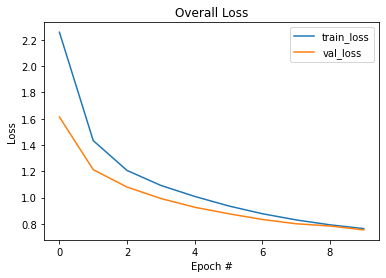

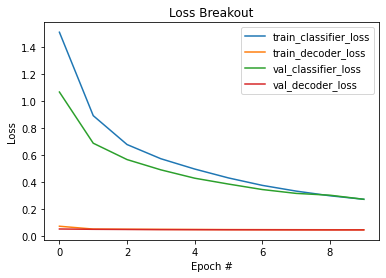

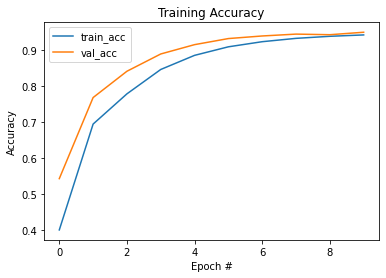

In [9]:
# construct a plot that plots and saves the training history
# plt.style.use("ggplot")
plt.figure()
plt.plot(hist.epoch, hist.history["loss"], label="train_loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="val_loss")
plt.title("Overall Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('total_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["classifier_loss"], label="train_classifier_loss")
plt.plot(hist.epoch, hist.history["decoder_loss"], label="train_decoder_loss")
plt.plot(hist.epoch, hist.history["val_classifier_loss"], label="val_classifier_loss")
plt.plot(hist.epoch, hist.history["val_decoder_loss"], label="val_decoder_loss")
plt.title("Loss Breakout")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('indiv_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["classifier_accuracy"], label="train_acc")
plt.plot(hist.epoch, hist.history["val_classifier_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('classifier_acc.png')
plt.show()



Test Accuracy: 0.9417
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.95      0.98      0.96      1135
           2       0.96      0.93      0.95      1032
           3       0.94      0.93      0.93      1010
           4       0.87      0.97      0.92       982
           5       0.94      0.93      0.93       892
           6       0.98      0.96      0.97       958
           7       0.97      0.94      0.95      1028
           8       0.92      0.87      0.89       974
           9       0.91      0.94      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



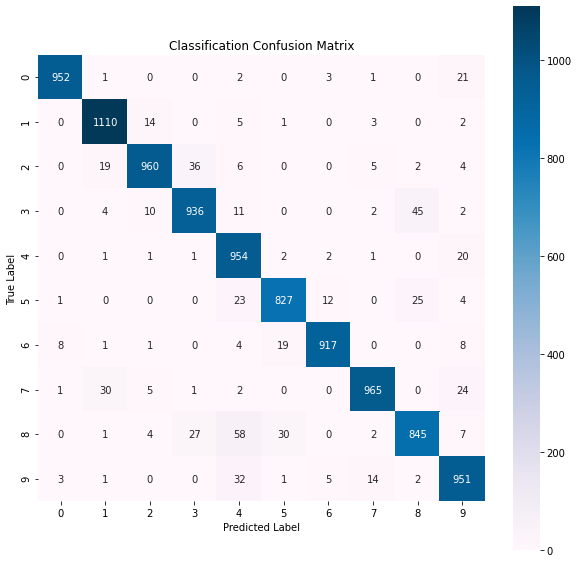

In [10]:
# Check accuracy

# Encode the input image
z = enc(x_test)

# Classify the latent code
y_pred = clf(z)

m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_test_one_hot, y_pred)
print('Test Accuracy:', m.result().numpy())

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()


## Show some reconstructions

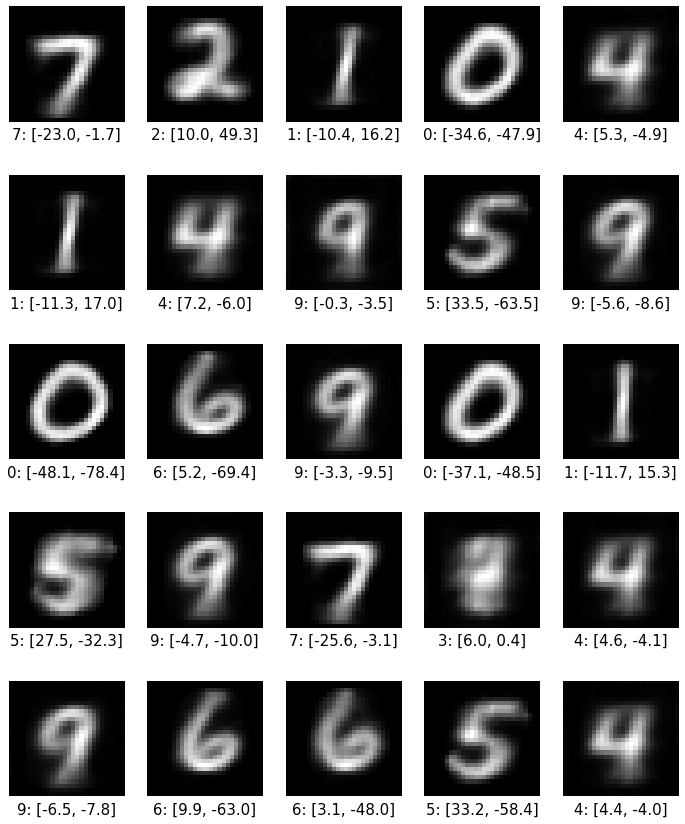

In [11]:
figsize = 12

latent = enc.predict(x_test[:25])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 15))
#fig.subplots_adjust(wspace=-0.021)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    plt.text(0.5, -0.15, '{}: [{:.1f}, {:.1f}]'.format(y_test[i], latent[i, 0], latent[i, 1]), fontsize=15, ha='center', transform=ax.transAxes)
    #plt.subplots_adjust(wspace=None, hspace=None)
    plt.imshow(reconst[i, :,:,0]*255, cmap = 'gray')
plt.show()

## Display how the latent space clusters different digit classes

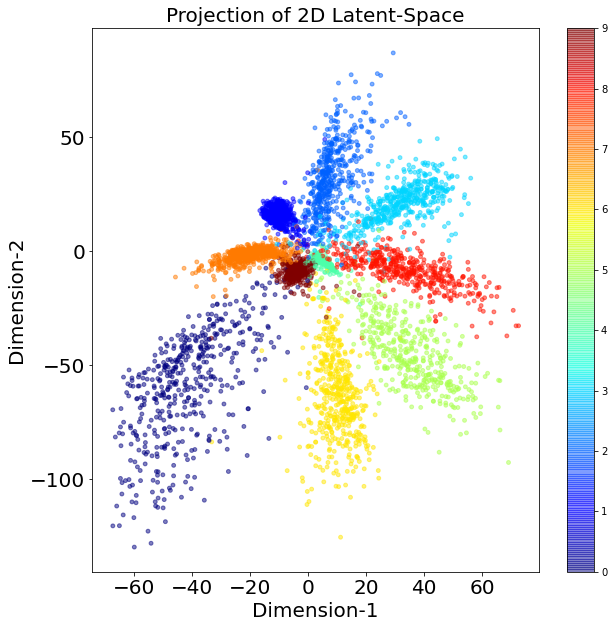

In [12]:
imgs_visualize = 5000
figsize = 10

def plot_label_clusters(data, labels, use_pca=False):
    # display a 2D plot of the digit classes in the latent space
    z = enc.predict(data)

    if use_pca:
      pca = PCA(n_components=2)
      pca.fit(data)
      z = pca.transform(z)


    plt.figure(figsize=(figsize, figsize))
    plt.scatter(z[:, 0], z[:, 1], 15, c=labels, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.xlabel("Dimension-1", size=20)
    plt.ylabel("Dimension-2", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Projection of 2D Latent-Space", size=20)
    plt.show()

plot_label_clusters(x_train[:imgs_visualize], y_train[:imgs_visualize])


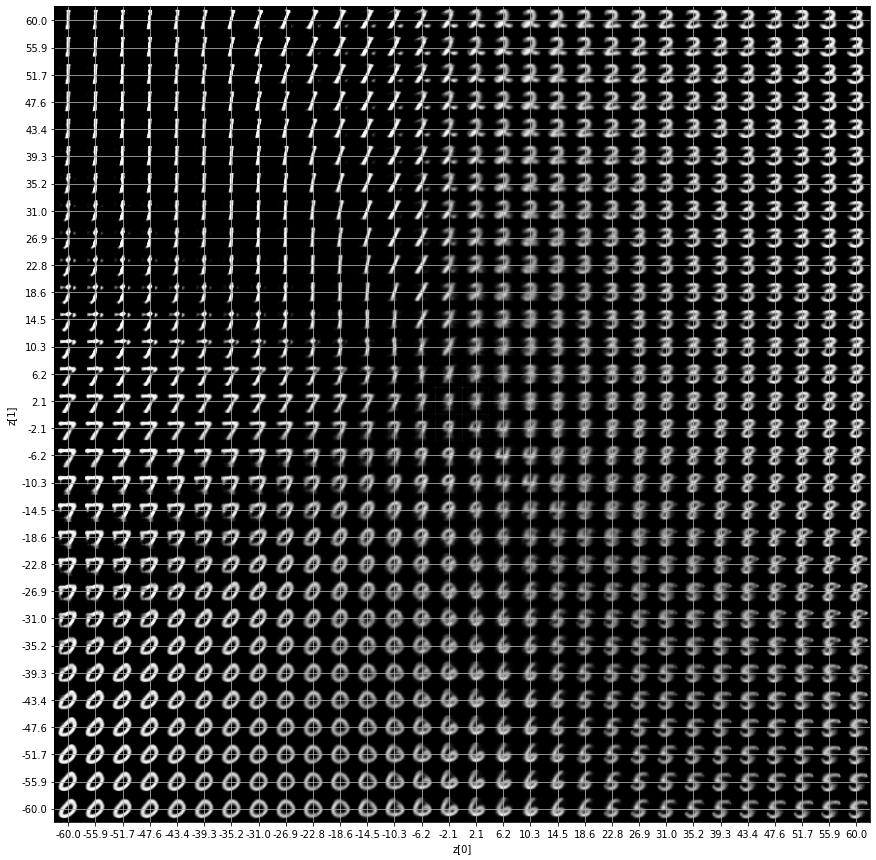

In [14]:
def plot_latent_space(model, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 60.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = dec.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.grid('off')
    plt.show()


plot_latent_space(model)